# **Step 1. Setup the environment**

In [1]:
%%capture
!pip install -q scanpy==1.10.1
!pip install -q anndata==0.10.7
!pip install -q leidenalg==0.10.2
!pip install google-cloud-storage


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc_context

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

Follow the instruction to allow access to google drive to save data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth # Authenticate your Colab environment to access your Google Cloud account.
auth.authenticate_user()

Mounted at /content/drive


# **Step 2. Load data and create a scanpy object**

In [4]:
# directly load data from https://info.vizgen.com/protein-co-detection-showcase?submissionGuid=b2c89505-7fbc-453a-bbe0-0add9691c2fe
cell_by_gene_csv = 'gs://vz-ffpe-showcase/HumanUterineCancerPatient2-ROCostain/cell_by_gene.csv'
meta_cell_csv = 'gs://vz-ffpe-showcase/HumanUterineCancerPatient2-ROCostain/cell_metadata.csv'

In [5]:
def make_AnnData(cell_by_gene_path, meta_cell_path, frac, random_state): # downsize to fit ram

    cell_by_gene = pd.read_csv(cell_by_gene_path, index_col=0)
    cell_by_gene.index = [str(i) for i in cell_by_gene.index] # this ensure the cell IDs are strings
    cell_by_gene = cell_by_gene.sample(frac = frac, random_state= random_state)

    meta_cell = pd.read_csv(meta_cell_path, index_col=0)
    meta_cell.index = [str(i) for i in meta_cell.index] # this ensure the cell IDs are strings
    meta_cell = meta_cell.sample(frac = frac, random_state= random_state)

    meta_cell['barcodeCount'] = cell_by_gene.sum(axis=1)

    # initialize meta_gene
    meta_gene = pd.DataFrame(index=cell_by_gene.columns.tolist())

    # Align the cell id of cell_by_gene and cell_metadata
    cell_id = cell_by_gene.index.tolist()
    meta_cell = meta_cell.loc[cell_id]

    coordinates =np.stack((meta_cell['center_x'], meta_cell['center_y']), axis=1)

    ad = sc.AnnData(X=cell_by_gene.values, obs=meta_cell, var=meta_gene, obsm={"spatial": coordinates})
    return ad

In [6]:
ad = make_AnnData(cell_by_gene_csv, meta_cell_csv, frac = 0.1, random_state=1128)
# Filtering out blank genes
ad = ad[:, ad.var_names.str.startswith('Blank-')==False]

# save all cell IDs for later importing into the Vizualizer
all_cell_IDs = ad.obs.index.copy()

# Storing the counts for later use
ad.layers["counts"] = ad.X.copy()

ad

<ipython-input-6-24ad12793db7>:9: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  ad.layers["counts"] = ad.X.copy()


AnnData object with n_obs × n_vars = 75851 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Anti-Ms-CD45RO_raw', 'Anti-Ms-CD45RO_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'barcodeCount'
    obsm: 'spatial'
    layers: 'counts'

In [7]:
ad.write_h5ad("/content/drive/MyDrive/Cancer sc analysis/HumanUterineCancerPatient2-ROCostain.hdf5")

# **Step 3. Single cell anaysis**

## Preprocessing

### Calculate total cell number before filtering

In [8]:
print("Cell number before filtering = ", len(ad))


Cell number before filtering =  75851


### Visualize gene expression counts distribution before filtering

<Axes: >

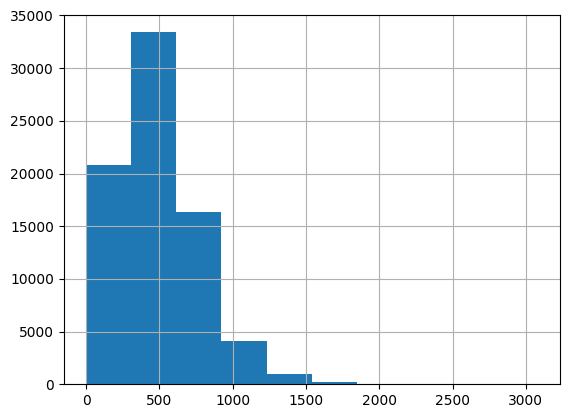

In [9]:
# ad.obs.barcodeCount.hist(bins=100,  range= [0,500])
ad.obs.barcodeCount.hist()

### Visualize volume distribution before filtering

<Axes: >

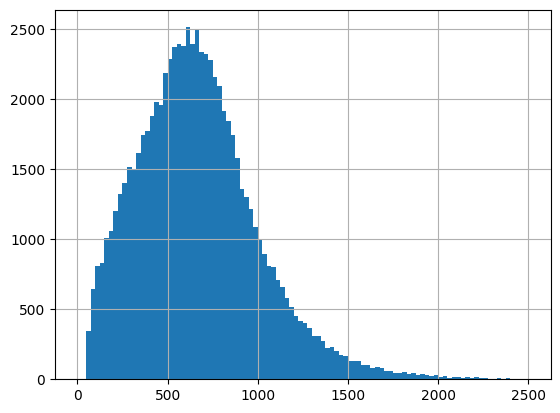

In [10]:
ad.obs.volume.hist(bins=100, range= [0,2500])

### Filter cells based on minimum gene expression counts and volume
**Set up total gene counts and volume thresholds to filter cells that don't pass the criteria:**

THE VALUES PROVIDED HERE ARE EXAMPLES.
*  **min_barcode_count_threshold:** A minimal barcode_count_threshold value removes low quality cells and poorly segmented cells.
*  The choice of the 'min_barcode_count_threshold' filtering parameter varies based on the data, tissue quality, and the genes you're looking at. Initially, go for a lenient setting and then visualize the results in the MERFISH Vizualizer. If any clusters look unnatural due to the lenient setting, you can then adjust and tighten the parameter for better accuracy
*  **volume_upper_threshold and volume_lower_threshold:** The unit for cell volume is expressed in microns. Users can utilize the MERSCOPE Vizualizer to estimate the volume by multiplying the area and thickness.


In [11]:
# set the threshold
min_barcode_count_threshold = 20
volume_upper_threshold = 2500
volume_lower_threshold = 100

selectCells = ad.obs[(ad.obs.volume < volume_upper_threshold)
                   & (ad.obs.volume > volume_lower_threshold)
                   & (ad.obs.barcodeCount > min_barcode_count_threshold)].index

### Calculate total cell number after filtering

In [12]:
ad = ad[selectCells].copy()
print("Cell number after filtering = ", len(ad))

Cell number after filtering =  74392


### Normalize barcode counts by cell volume
To account for variations in cell volume due to different cutting angles and areas, I normalized transcript counts to the median cell volume. This normalization helps address the tendency of larger volume cells to have more transcripts detected.

In [13]:
ad.obs['volume_factor'] = ad.obs['volume']/np.median(ad.obs['volume'])
ad.X = np.divide(ad.X, np.array(ad.obs['volume_factor']).reshape(-1, 1))

### Normalize barcode counts by total counts over all genes and log transform data


*   **sc.pp.normalize_total:** Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization
*   **sc.pp.log1p:** Logarithmize the gene count matrix in the .X attribute. This reduces the impact of highly expressed genes (skewed distribution of expression values) and allowing for a more balanced representation of the data.



In [14]:
sc.pp.normalize_total(ad)
sc.pp.log1p(ad)

normalizing counts per cell
    finished (0:00:00)


### Store raw data in the .raw attribute before scaling
This information will be used for later rank gene analysis

In [15]:
ad.raw = ad.copy()

### scale gene counts
*   **sc.pp.scale:** Scale data to unit variance and zero mean. Clip values exceeding standard deviation 10 to reduce the impact of outliers or highly variable genes.

In [16]:
sc.pp.scale(ad, max_value=10)

## Dimension reduction by Principal component analysis (PCA)
PCA reduces the high-dimensional gene expression data to a lower-dimensional space while retaining the most informative variation.

computing PCA
    with n_comps=50
    finished (0:00:26)


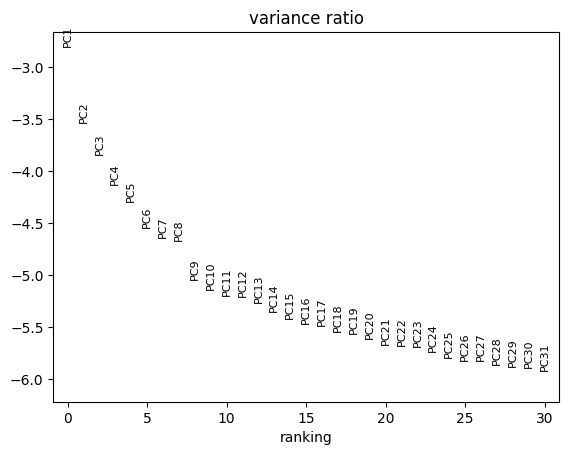

In [17]:
sc.tl.pca(ad, svd_solver='arpack')
sc.pl.pca_variance_ratio(ad, log=True) # use elbow plot to determine the number of PCs

PCs are arranged based on their contribution to the variance of the data. The number of PCs selected for subsequent analysis should be determined by identifying the point where the 'elbow' occurs, indicating a significant decrease in variance.

It's important to consider a trade-off when choosing the number of PCs. Including more PCs will capture a greater amount of variation in the data. However, minor PCs (with less y axis value in the elbow plot) tend to contribute less to the overall variance and can slow down the subsequent analysis process. The minor principal components capture finer, often noisier details of the data.

## Connect neighbors and embed on UMAP

**sc.pp.neighbors**
*   **n_neighbors:** Determines the number of nearest neighbors used to construct the neighborhood graph to represent the connectivity between cells . Here are a few considerations:


1.   **Local vs. global structure:** Smaller values of n_neighbors (e.g., 5-15) capture more local interactions, revealing fine-scale structure within cell populations. Larger values (e.g., 30-50 or more) capture more global interactions, providing a broader view of the data.
2.   **Computational efficiency:** Constructing the neighborhood graph involves calculating pairwise distances between cells, which can be computationally expensive for large datasets. Higher values of n_neighbors increase the computational burden, so it's essential to balance accuracy with computational constraints.
3.   **Resolution:** The choice of n_neighbors influences downstream analyses such as clustering and dimensionality reduction. Higher values of n_neighbors tend to result in smoother, more aggregated clusters, while lower values lead to finer, more detailed clustering.
4.  **Overfitting:** Using too few neighbors (e.g., 2 or 3) can result in spurious connections and noisy graphs. On the other hand, excessively large values can lead to over-smoothing, where the graph becomes too homogeneous and may hide meaningful biological variation.

*   **n_pcs:** set the number of PCs used. The choice of n_pcs depends on several factors:


1.  **Data complexity:** Complex datasets with many cell types, subpopulations, or biological processes may require a larger number of PCs to capture the variation adequately. Conversely, simpler datasets with fewer distinct cell types or less heterogeneity may require fewer PCs.
2.  **Computational efficiency:** The computational cost of performing PCA increases with the number of PCs. Therefore, it's important to consider the trade-off between computational resources and the desired level of dimensionality reduction. For large datasets, a reduced number of PCs might be preferred to optimize runtime.
3. **Data quality:** The number of informative PCs can be influenced by various factors, including cell quality, and noise levels. Exploring the variance explained by each PC and analyzing elbow plot can help determine the number of significant PCs to retain.
4. **Downstream analysis:** The number of PCs chosen can impact subsequent analyses, such as clustering or visualization. Using too few PCs might result in poor separation or resolution of cell populations, while using too many might obscure meaningful biological variation.


**sc.tl.umap**  perform a nonlinear dimensionality reduction using UMAP algorithm. I prefer using default min_dist and spread parameter for balanced  dispersal of points.



In [18]:
sc.pp.neighbors(ad) # use default setting is good enough for the current analysis. # we can revisit this part later if we find any granular cell types within clusters.
sc.tl.umap(ad)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:43)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:34)


## Cluster cells using the Leiden algorithm
**sc.tl.leiden**

*   **resolution:**  determines the granularity of the clustering. It influences the level of detail in the resulting clusters. A higher value of resolution leads to more fine-grained clusters, while a lower value produces more coarse-grained clusters. When resolution is set to a low value (e.g., 0.1 or 0.2), the algorithm tends to merge similar cell populations into larger clusters, resulting in fewer but more general clusters.
Conversely, a higher value for resolution (e.g., 1.0 or higher) encourages the algorithm to identify smaller, more distinct cell populations, resulting in a larger number of more specific clusters.
<br>The choice of resolution depends on the desired level of granularity in the clustering results.

*  **use_weights:** determines whether to incorporate edge weights during the clustering process. Edge weights represent the strength of connections between cells in the neighborhood graph used by the Leiden algorithm.
> When **use_weights=True**, the algorithm considers both the connectivity between cells and the strength (or similarity) associated with those connections. Edge weights are often calculated based on shared nearest neighbors or other similarity measures. Stronger edges, represented by higher weights, indicate a higher degree of similarity between cells. These connections are considered more informative and influential in determining the clustering structure.
<br>Setting **use_weights=False** ignores the edge weights, treating all connections equally and solely relying on the graph's topology for clustering.

By incorporating edge weights, the Leiden algorithm can potentially capture more nuanced patterns in the data, especially when there are strong connections or shared characteristics between cells that can be identified through the graph's topology.

The choice of whether to use weights depends on the data characteristics and the quality of the neighborhood graph. In some cases, incorporating weights can improve the clustering accuracy, especially when the graph captures relevant biological information. However, in other cases, using weights may not significantly impact the results, or it may introduce noise if the weights are not informative.

It's important to note that these parameters, along with other parameters such as **n_neighbors** of **sc.pp.neighbors**, influence the outcome of the clustering analysis.

In [19]:
sc.tl.leiden(ad, resolution=1.5)

running Leiden clustering


<ipython-input-19-6e933aaf3670>:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(ad, resolution=1.5)


    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:04:29)


# **Step 4. Visualize clusters on UMAP and spatial distribution**

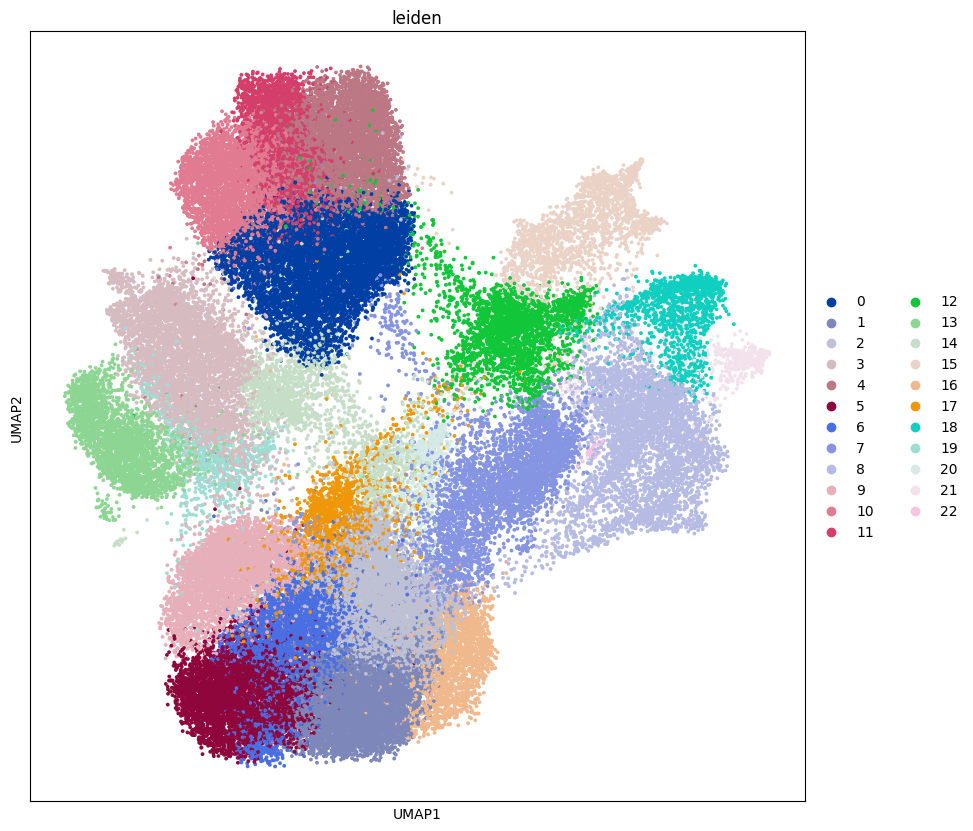

In [20]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(ad, color="leiden", size= 30, alpha = 1)

You can set **spot_size** to adjust cell center granuality

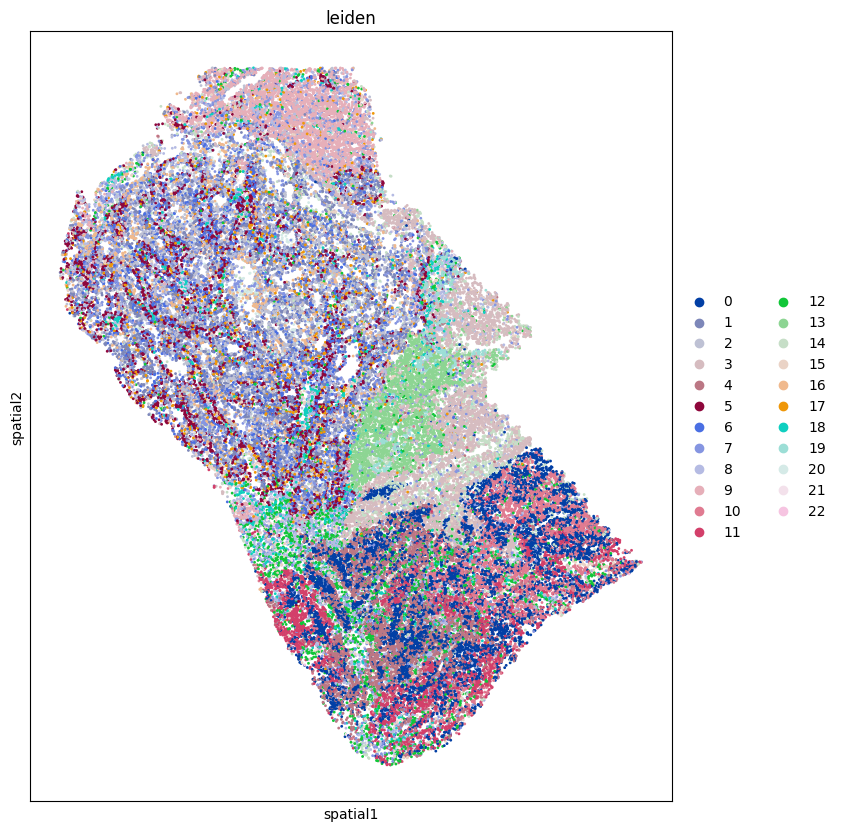

In [21]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(ad, color='leiden', spot_size=50, alpha = 1)

In [22]:
ad.write_h5ad("/content/drive/MyDrive/Cancer sc analysis/HumanUterineCancerPatient2-ROCostain.hdf5")

## Rank genes (Differential expression)
**sc.tl.rank_genes_groups:** Identify genes that are differentially expressed between different cell populations or groups.

**sc.pl.rank_genes_groups**


> **n_genes:** Number of genes to show.
<br>The **scores** on the y-axis are the z-score underlying the computation of a p-value for each gene for each group.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:26)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:434: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

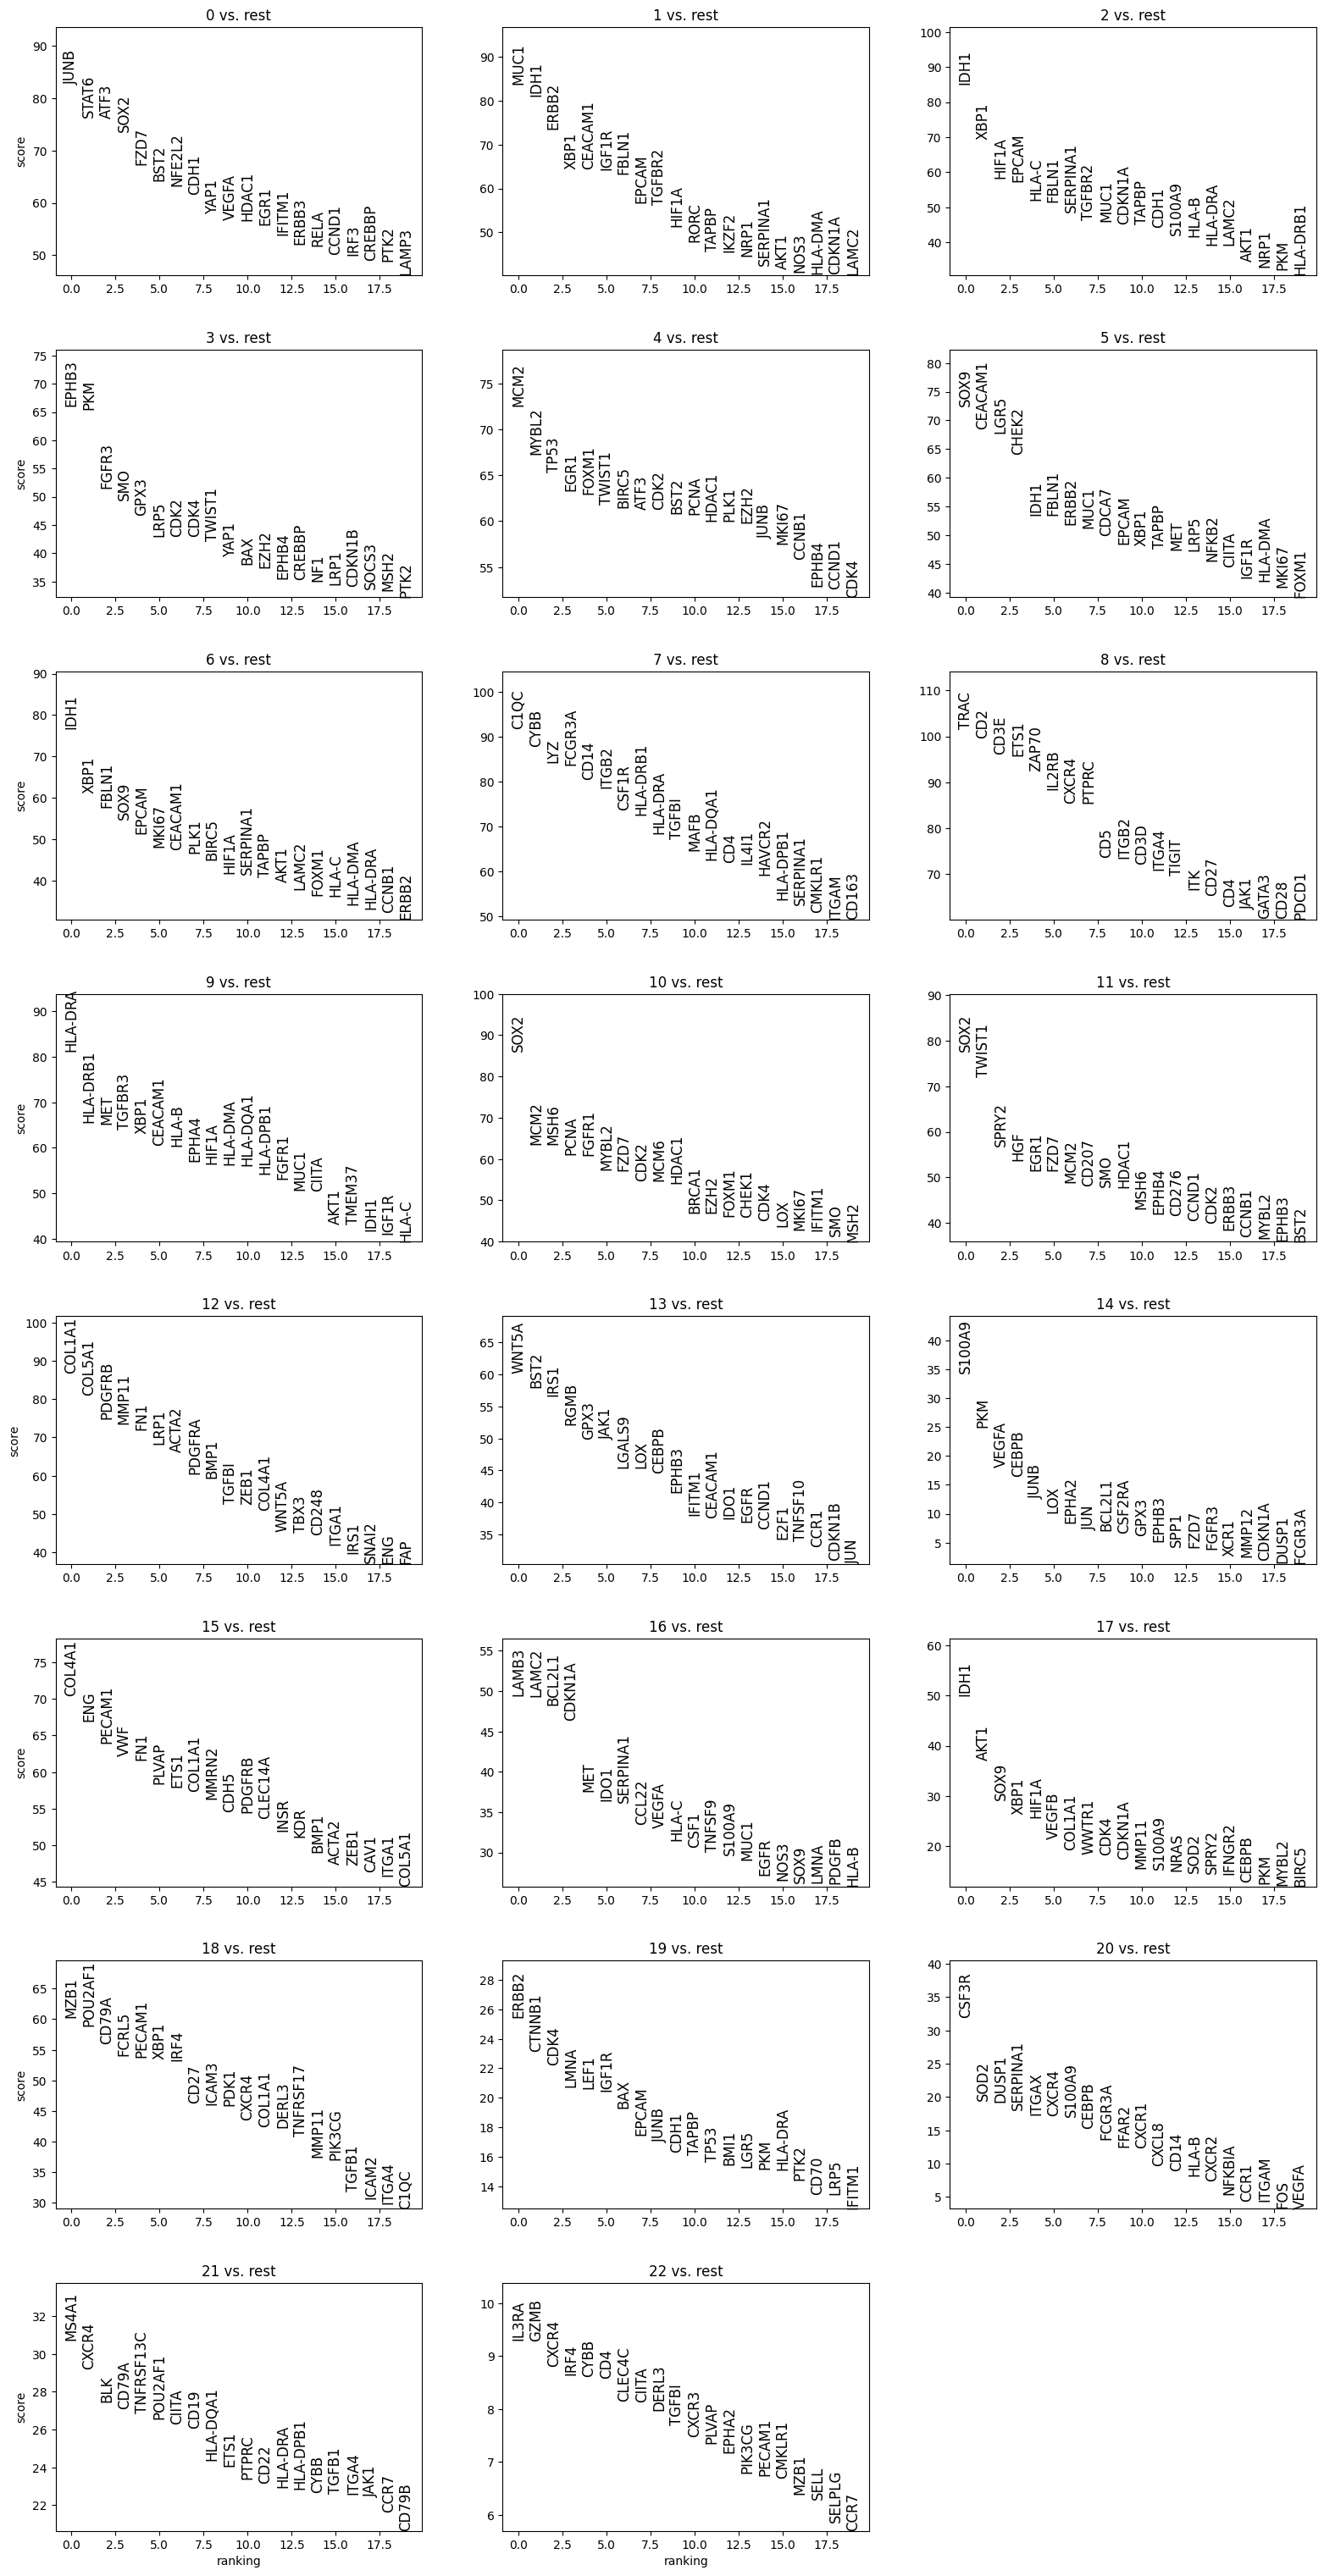

In [23]:
sc.tl.rank_genes_groups(ad, groupby='leiden', method='wilcoxon')
# sc.pl.rank_genes_groups(ad, n_genes=25, sharey=False)
sc.pl.rank_genes_groups(ad, n_genes=20, fontsize=12, ncols=3, sharey=False)

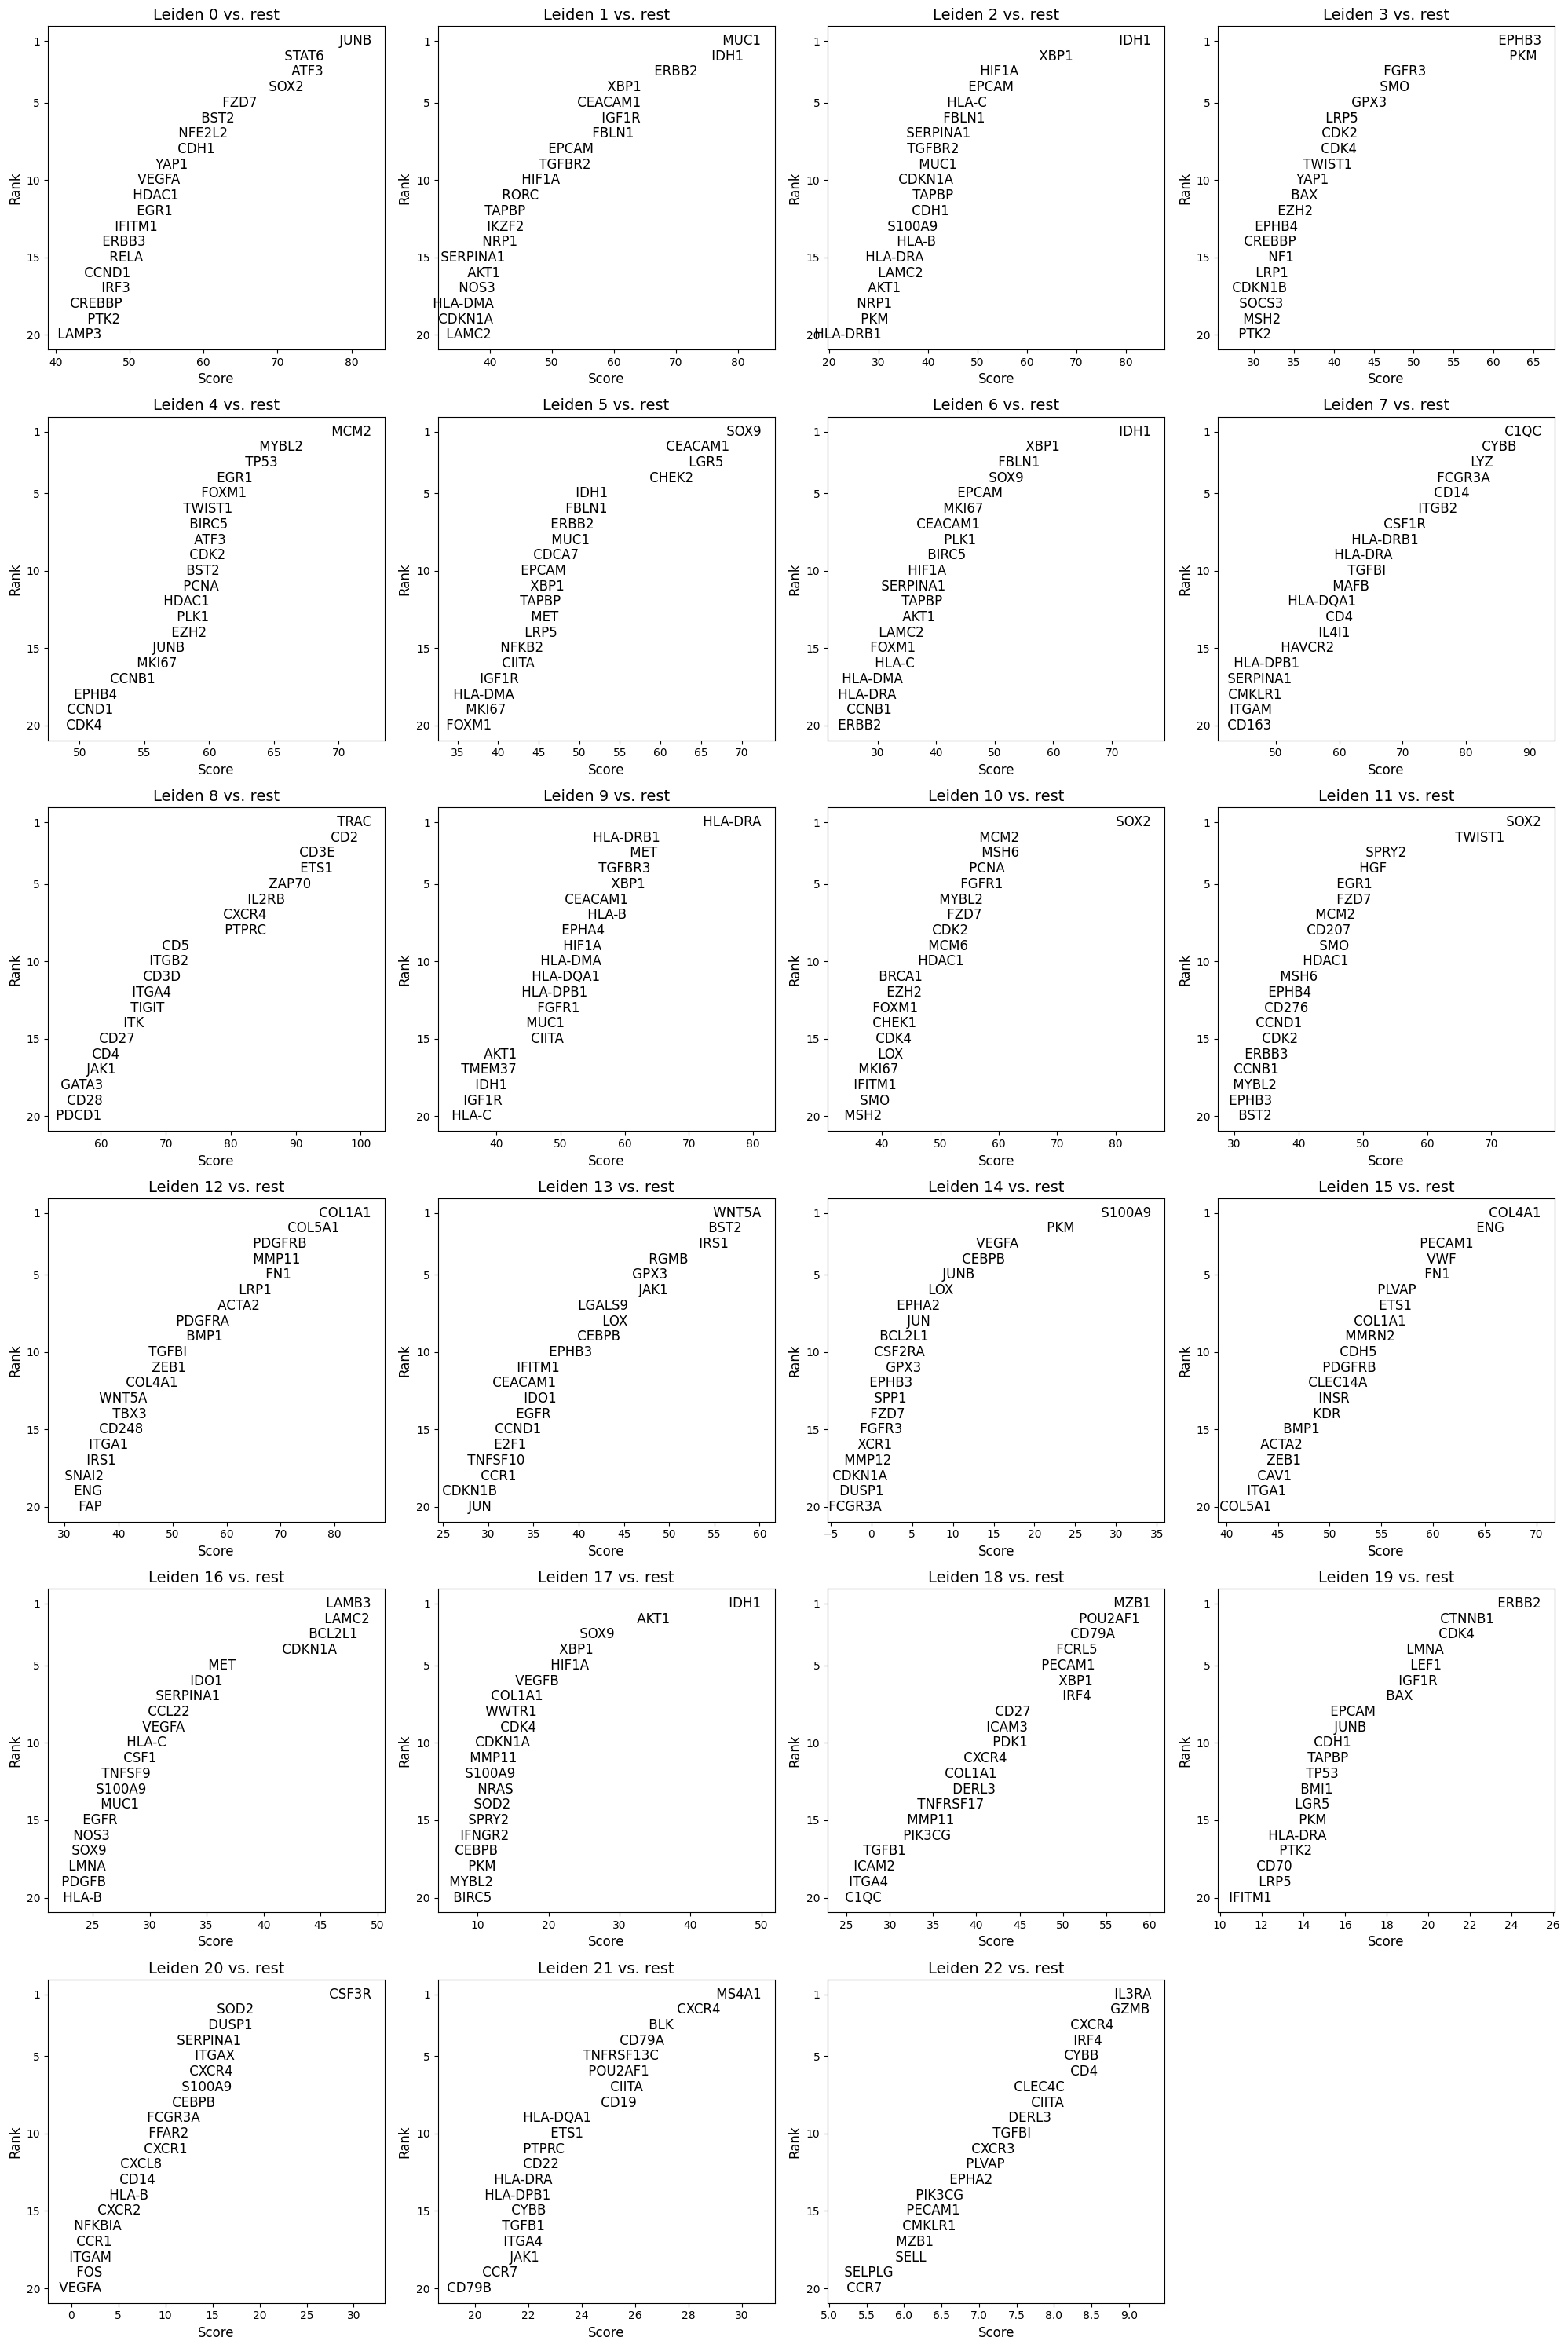

In [24]:
# swop x and y axis to make gene names in horizontal for better visualization

# Number of clusters
n_clusters = 23
n_rows = 6
n_cols = 4
n_genes = 20  # Number of genes to visualize

# Define subplot size
subplot_width = 5  # Width of each subplot
subplot_height = 5  # Height of each subplot

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * subplot_width, n_rows * subplot_height))
axes = axes.flatten()  # Flatten the grid to iterate easily

# Loop over each Leiden cluster
for i in range(n_clusters):
    group = str(i)  # Leiden cluster name as a string
    ax = axes[i]  # Select the corresponding subplot

    # Extract rank genes information
    genes = ad.uns['rank_genes_groups']['names'][group][:n_genes]
    scores = ad.uns['rank_genes_groups']['scores'][group][:n_genes]

    # Creating a DataFrame for ease of plotting
    data = pd.DataFrame({'Rank': range(1, n_genes + 1), 'Gene': genes, 'Score': scores})

    # Plotting on the subplot
    ax.scatter(data['Score'], data['Rank'], color='blue', s=0)  # Make dots invisible by setting size to 0
    ax.invert_yaxis()  # Invert y-axis to have rank 1 at the top

    # Adding gene name labels next to dots
    for j, row in data.iterrows():
        ax.text(row['Score'], row['Rank'], f" {row['Gene']}", va='center', ha='right', fontsize=12)

    # Adjusting y-axis to show only specific ranks
    ax.set_yticks([1, 5, 10, 15, 20])
    ax.set_yticklabels([1, 5, 10, 15, 20])
    ax.tick_params(axis='x', labelsize=10)  # Adjust x-axis tick size
    ax.tick_params(axis='y', labelsize=10)  # Adjust y-axis tick size

    # Adjusting x-axis min
    xmin = data['Score'].min() - (data['Score'].max()-data['Score'].min())*.2
    ax.set_xlim(xmin, None)  # Set xmin, leaving xmax as automatic

    # Formatting the subplot
    ax.set_title(f'Leiden {group} vs. rest', fontsize=14)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Rank', fontsize=12)

# Leave the last subplot blank
for i in range(n_clusters, len(axes)):
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Plot ranking of genes using dotplot
To gain insights into the genes that are most significantly associated with each cell group and visualize the fraction of cells within each group that express those genes.

You can set **n_genes** to adjust the number of top-ranked genes to include in the dotplot.



    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


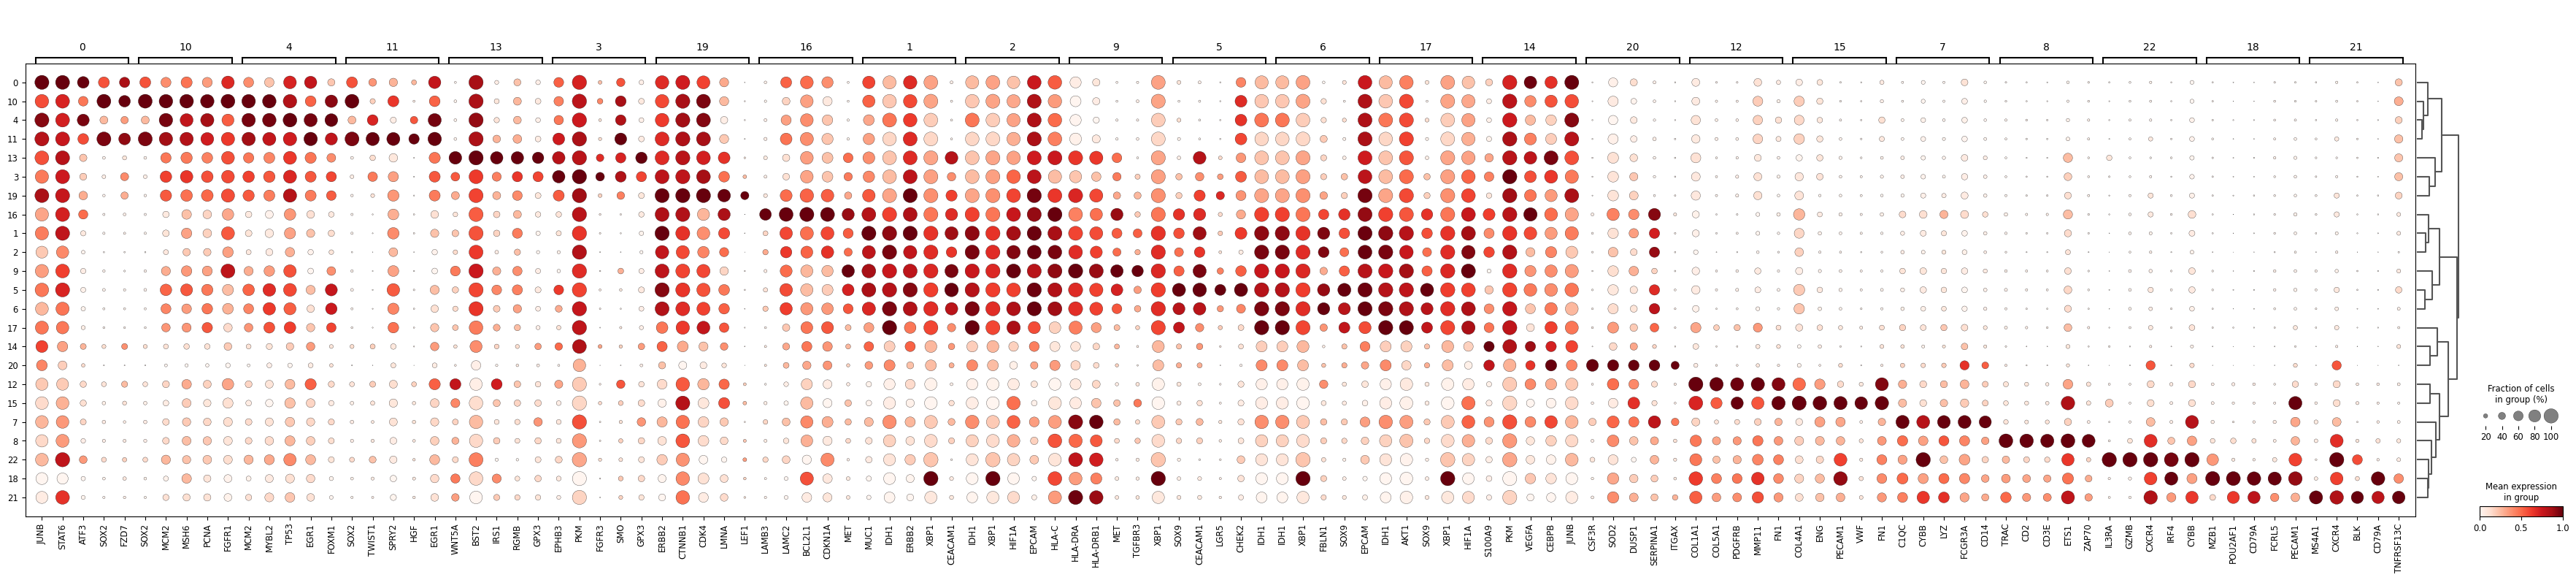

In [25]:
sc.pl.rank_genes_groups_dotplot(ad, groupby='leiden',n_genes=5, standard_scale='var')

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Monocytes, T-cell, etc.


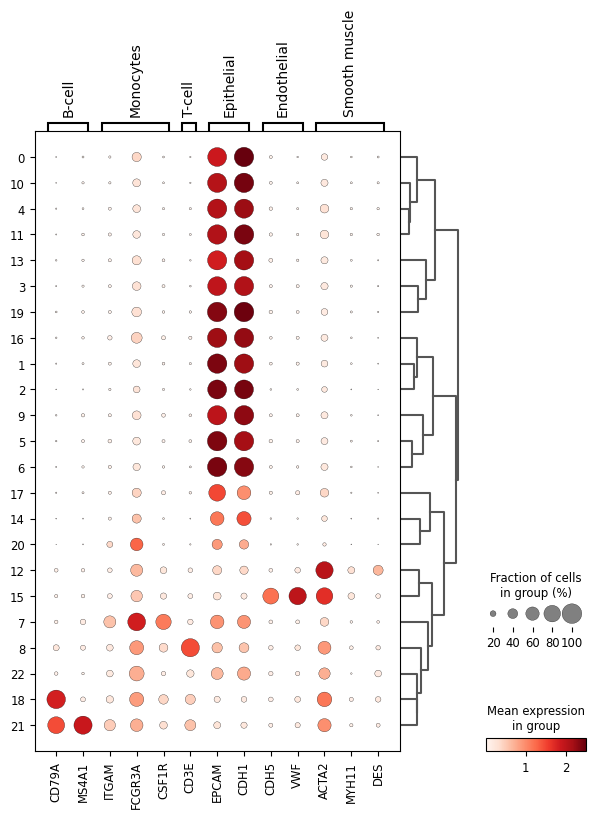

In [26]:
marker_genes_dict = {
    'B-cell': ['CD79A', 'MS4A1'],
    'Monocytes': ['ITGAM','FCGR3A','CSF1R'],
    'T-cell': ['CD3E'],
    'Epithelial':['EPCAM', 'CDH1'],
    'Endothelial':['CDH5', 'VWF'],
    'Smooth muscle': ['ACTA2','MYH11','DES'],
}

sc.pl.dotplot(ad, marker_genes_dict, 'leiden', dendrogram=True)

## Assign cell type identity based on the above gene enrichment analysis

*   Before running the following chunk, follow the format **"cluster number" : "new cluster name",** to annotate individual clusters.
    <br>The syntax **"text":"text",** will ensure correct assignment.
*   Two or more clusters can be assigned the same name.

*   Any un-annotated clusters will be assigned as 'other' by default

In [27]:
ad.obs["manual_annot"] = ad.obs["leiden"].map({"0" : "Cancer cell_1",
                                                "1" : "Cancer cell_2",
                                                "2" : "Cancer cell_3",
                                                "3" : "Cancer cell_4",
                                                "4" : "Cancer cell_5",
                                                "5" : "Endometrium",
                                                "6" : "Endometrium",
                                                "7" : "Immune cell",
                                                "8" : "Immune cell (T Cell)",
                                                "9" : "Endometrium (antigen presenting)",
                                                "10" : "Cancer stem cell",
                                                "11" : "Cancer cell_6 (Metastasis)",
                                                "12" : "Smooth muscle",
                                                "13" : "Cancer cell_7",
                                                "14" : "Endometrium (inflammating)",
                                                "15" : "Endothelium",
                                                "16" : "Cancer cell_8 (Metastasis/Senescent)",
                                                "17" : "Endometrium",
                                                "18" : "Immune cell (B Cell)",
                                                "19" : "Cancer cell_9",
                                                "20" : "Endometrium (inflammating)",
                                                "21" : "Immune cell (B Cell)",
                                                "22" : "Immune cell (NK cell)"
                                                })

ad.obs["manual_annot"] = ad.obs["manual_annot"].replace(np.nan, "other")

## Project annotated clusters on UMAP and spatial plots

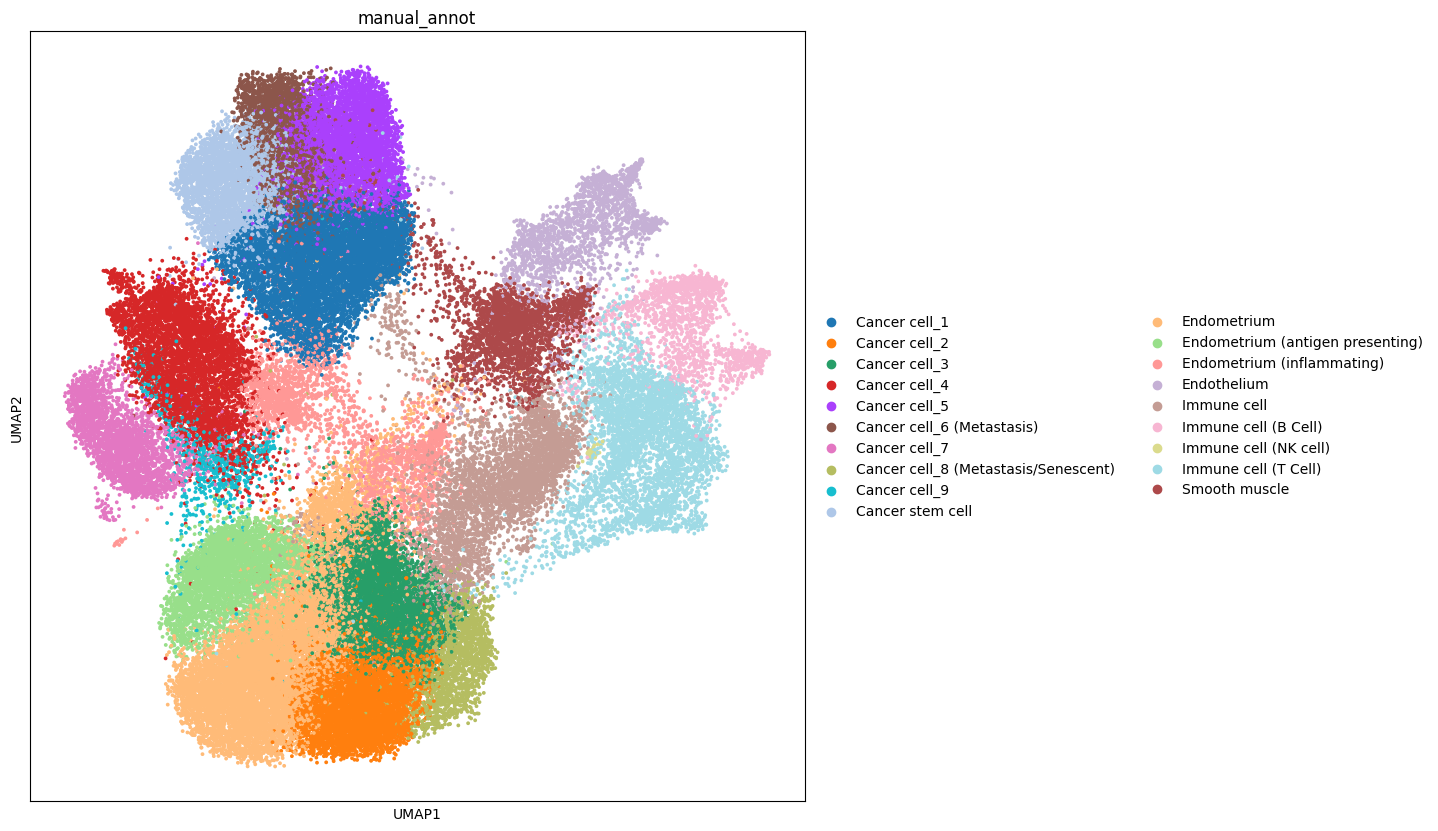

In [28]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(ad, color="manual_annot", size= 30, alpha = 1)

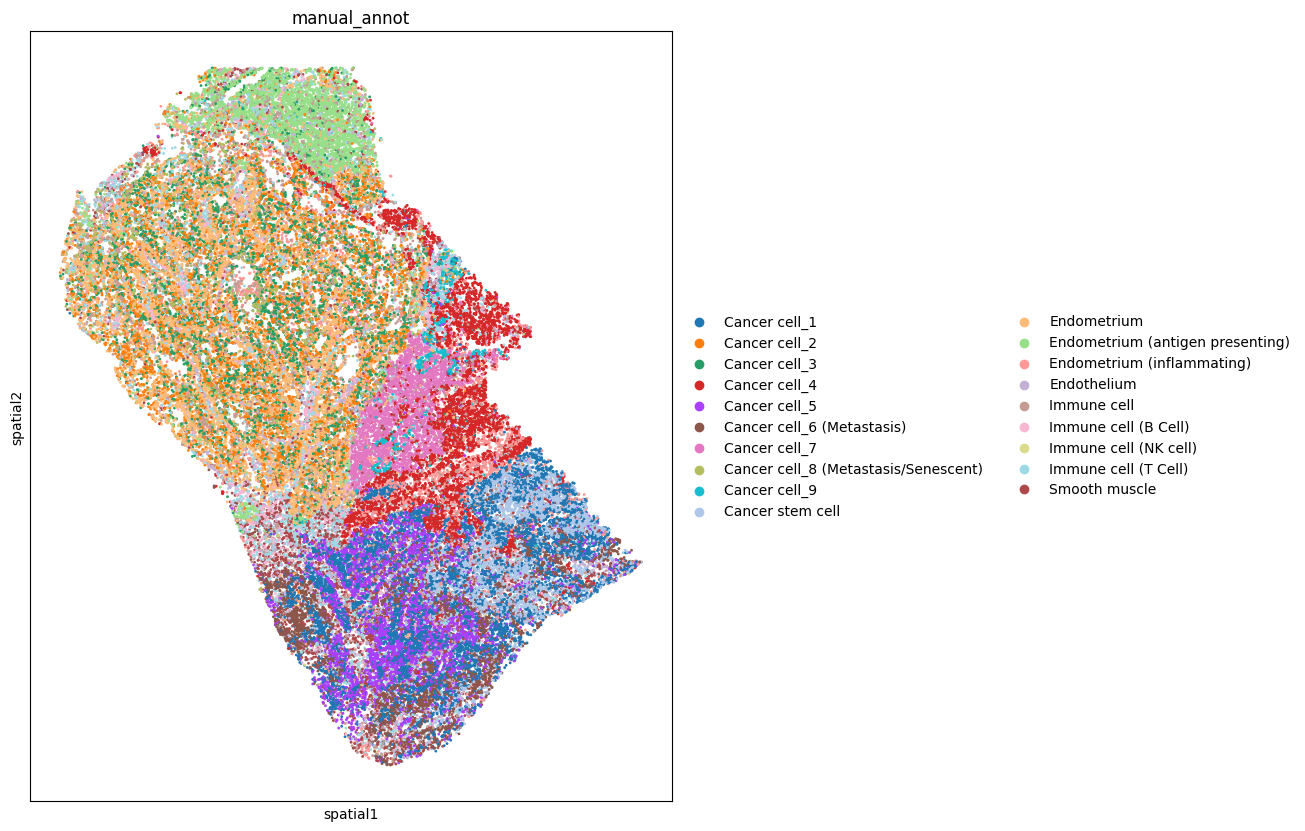

In [30]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(ad, color = 'manual_annot', spot_size= 50, alpha = 1)

In [31]:
ad.write_h5ad("/content/drive/MyDrive/Cancer sc analysis/HumanUterineCancerPatient2-ROCostain_annotated.hdf5")

# Print the environment set up

In [32]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.10
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             5.5.0
anndata                            0.10.7
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_api_compat                   1.9.1
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2024.12.16.0.35.48
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic         